# **Distilling the Knowledge in a Neural Network**

Paper Url: https://arxiv.org/pdf/1503.02531.pdf

The goal of knowledge distillation is to create a smaller model that can learn from a larger, more complex model. This smaller model performs better than typical small models and is easier to use in real-world applications.

In this setup, the large model is called the "teacher" model, and the smaller model is the "student" model. The teacher model gives high probabilities to the correct answer and lower probabilities to other answers, showing how it generalizes.

For example, if the teacher model sees a picture of a dog, it might slightly consider “cat” as a possibility but would hardly consider “truck.” The student model is trained to copy the teacher model’s way of thinking, learning from its outputs. This approach helps the student become more accurate and efficient, making it a good choice for deployment. The following image is a simple explanation of how "teacher" transfers knowledge to "student".

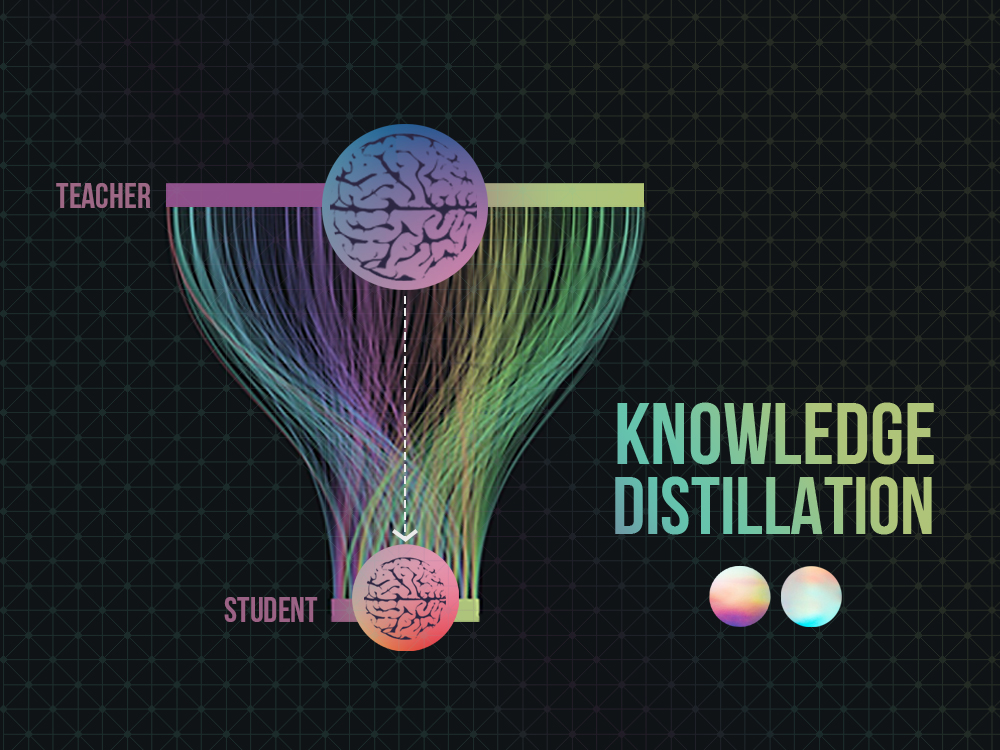

## **Initialisation of the libraries**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
import numpy as np
import os
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

## **Dataset**

In [ ]:
!git clone http://github.com/pytorch/examples
os.chdir('examples/mnist')

Cloning into 'examples'...
remote: Enumerating objects: 4343, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 4343 (delta 15), reused 32 (delta 10), pack-reused 4283 (from 1)
Receiving objects: 100% (4343/4343), 41.38 MiB | 12.01 MiB/s, done.
Resolving deltas: 100% (2164/2164), done.


In [ ]:
import warnings
import ssl
import torch
from torchvision import datasets, transforms

# Suppress SSL certificate verification warnings (if needed)
ssl._create_default_https_context = ssl._create_unverified_context

# Suppress SSL warnings
warnings.filterwarnings("ignore", category=UserWarning, module="urllib3")

# Transforming the dataset to tensors and adding translation to the trainset
transformtrain = transforms.Compose([
    transforms.RandomAffine(0, translate=(0.07, 0)),  # Random affine transformation with translation
    transforms.ToTensor()
])

transform = transforms.Compose([transforms.ToTensor()])

# Downloading the training set (transformation applied only to trainset) and test set
trainset = datasets.MNIST(root='/content/examples/data', download=True, transform=transformtrain)
testset = datasets.MNIST(root='/content/examples/data', download=True, transform=transform, train=False)

# Batchsize of 100 used for loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True, num_workers=2)

# Print dataset sizes
print(len(trainset), len(testset))


60000 10000


## **Network architecture**

Defining the model architecture of the teacher and student network

**TeacherNetwork** - 2 hidden layer 1200 units

**StudentNetwork** - 2 hidden layer 800 units

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

use_gpu = torch.cuda.is_available()

class TeacherNetwork(nn.Module):
    def __init__(self):
        super(TeacherNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, 10)
        self.dropout_input = 0.0
        self.dropout_hidden = 0.0
        self.is_training = True

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.dropout(x, p=self.dropout_input, training=self.is_training)
        x = F.dropout(F.relu(self.fc1(x)), p=self.dropout_hidden, training=self.is_training)
        x = F.dropout(F.relu(self.fc2(x)), p=self.dropout_hidden, training=self.is_training)
        x = self.fc3(x)
        return x

class StudentNetwork(nn.Module):
    def __init__(self):
        super(StudentNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 10)
        self.dropout_input = 0.0
        self.dropout_hidden = 0.0
        self.is_training = True

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.dropout(x, p=self.dropout_input, training=self.is_training)
        x = F.dropout(F.relu(self.fc1(x)), p=self.dropout_hidden, training=self.is_training)
        x = F.dropout(F.relu(self.fc2(x)), p=self.dropout_hidden, training=self.is_training)
        x = self.fc3(x)
        return x


## **Learning teacher network**


In [ ]:
teacherNetwork = TeacherNetwork()
if use_gpu:
    teacherNetwork = teacherNetwork.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacherNetwork.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

## **Training Teacher model**

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[1,   600] loss: 4.141
[2,   600] loss: 1.584
[3,   600] loss: 1.052
[4,   600] loss: 0.800
[5,   600] loss: 0.649
[6,   600] loss: 0.559
[7,   600] loss: 0.488
[8,   600] loss: 0.442
[9,   600] loss: 0.395
[10,   600] loss: 0.367
[11,   600] loss: 0.335
[12,   600] loss: 0.304
[13,   600] loss: 0.292
[14,   600] loss: 0.268
[15,   600] loss: 0.256
[16,   600] loss: 0.236
[17,   600] loss: 0.222
[18,   600] loss: 0.210
[19,   600] loss: 0.197
[20,   600] loss: 0.185
[21,   600] loss: 0.180
[22,   600] loss: 0.173
[23,   600] loss: 0.159
[24,   600] loss: 0.152
[25,   600] loss: 0.140
[26,   600] loss: 0.136
[27,   600] loss: 0.128
[28,   600] loss: 0.127
[29,   600] loss: 0.124
[30,   600] loss: 0.086
[31,   600] loss: 0.079
[32,   600] loss: 0.080
[33,   600] loss: 0.077
[34,   600] loss: 0.077
[35,   600] loss: 0.073
[36,   600] loss: 0.073
[37,   600] loss: 0.074
[38,   600] loss: 0.072
[39,   600] loss: 0.073
[40,   600] loss: 0.068
[41,   600] loss: 0.070
[42,   600] loss: 0.068
[

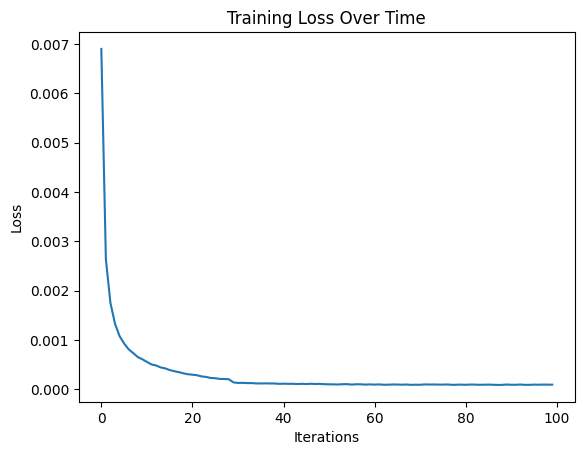

Finished Training


In [11]:
import matplotlib.pyplot as plt

loss_values = []  # Initialize the list to store loss values

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = teacherNetwork(inputs)
        loss = criterion(outputs, labels)

        # Optional: Add regularization loss
        # loss += lmbd * reg_loss

        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 600 == 599:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / len(trainset))  # Corrected indentation here
            running_loss = 0.0

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

print('Finished Training')


## **Evaluating Teacher model on test data**

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

teacherNetwork = teacherNetwork.to(device)  # Move the model to the selected device

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to the selected device
        outputs = teacherNetwork(images)  # Run forward pass on device
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if total % 1000 == 999:  # print every 1000 samples
            print('[%5d] completed' % (total + 1))

# Calculate and print accuracy
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))
wrong_pred = total - correct
print('Wrong predictions on the 10000 test images:', wrong_pred, 'out of', total)


Accuracy of the network on the 10000 test images: 98.85 %
Wrong predictions on the 10000 test images: 115 out of 10000


## **Learning Student network**

1. Without knowledge distillation

2. With knowledge distillation using soft target of trained teacher model

# **1. Without knowledge distillation**

In [14]:
studentnetwork_wodist = StudentNetwork()

if use_gpu:
    studentnetwork_wodist = studentnetwork_wodist.cuda()
optimizer1 = optim.SGD(studentnetwork_wodist.parameters(), lr=1e-2, momentum=0.9)
scheduler = StepLR(optimizer1, step_size=30, gamma=0.1)

## **Training student network without distillation**

[1,   100] loss: 1.870
[1,   200] loss: 0.701
[1,   300] loss: 0.528
[1,   400] loss: 0.469
[1,   500] loss: 0.389
[1,   600] loss: 0.370
[2,   100] loss: 0.335
[2,   200] loss: 0.304
[2,   300] loss: 0.277
[2,   400] loss: 0.255
[2,   500] loss: 0.251
[2,   600] loss: 0.228
[3,   100] loss: 0.212
[3,   200] loss: 0.191
[3,   300] loss: 0.175
[3,   400] loss: 0.167
[3,   500] loss: 0.163
[3,   600] loss: 0.161
[4,   100] loss: 0.146
[4,   200] loss: 0.140
[4,   300] loss: 0.126
[4,   400] loss: 0.131
[4,   500] loss: 0.135
[4,   600] loss: 0.131
[5,   100] loss: 0.116
[5,   200] loss: 0.117
[5,   300] loss: 0.105
[5,   400] loss: 0.112
[5,   500] loss: 0.107
[5,   600] loss: 0.113
[6,   100] loss: 0.103
[6,   200] loss: 0.094
[6,   300] loss: 0.091
[6,   400] loss: 0.094
[6,   500] loss: 0.095
[6,   600] loss: 0.096
[7,   100] loss: 0.090
[7,   200] loss: 0.081
[7,   300] loss: 0.085
[7,   400] loss: 0.077
[7,   500] loss: 0.093
[7,   600] loss: 0.072
[8,   100] loss: 0.085
[8,   200] 

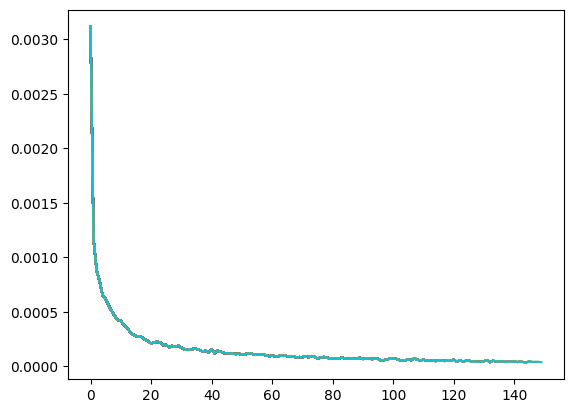

In [15]:
loss_values =[]
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer1.zero_grad()

        # forward + backward + optimize
        output_student = studentnetwork_wodist(inputs)
        loss = criterion(output_student, labels)
        loss.backward()
        optimizer1.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / len(trainset))
            running_loss = 0.0
            plt.plot(loss_values)
print('Finished Training')

# **Testing student network without distillation**

In [17]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the student network to the selected device
studentnetwork_wodist = studentnetwork_wodist.to(device)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move images and labels to the selected device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = studentnetwork_wodist(images)
        _, predicted = torch.max(outputs, 1)

        # Move predictions back to CPU for counting
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if total % 1000 == 999:  # Print every 1000 samples
            print('[%5d] completed' % (total + 1))

# Print final accuracy
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))
wrong_pred = total - correct
print('Wrong predictions on the 10000 test images:', wrong_pred, 'out of', total)


Accuracy of the network on the 10000 test images: 98.78 %
Wrong predictions on the 10000 test images: 122 out of 10000


## **2. With knowledge distillation**

In [18]:
studentnetwork_distil = StudentNetwork()

if use_gpu:
    studentnetwork_distil = studentnetwork_distil.cuda()

optimizer2 = optim.SGD(studentnetwork_distil .parameters(),  lr=1e-2, momentum=0.9)
T=20 #Temperature is initially set as 20
l = 0.3;
scheduler = StepLR(optimizer2, step_size=30, gamma=0.1)

# **Training student network with distillation**

[1,   100] loss: 15.661
[1,   200] loss: 3.826
[1,   300] loss: 1.888
[1,   400] loss: 1.095
[1,   500] loss: 0.771
[1,   600] loss: 0.592
[2,   100] loss: 0.461
[2,   200] loss: 0.386
[2,   300] loss: 0.338
[2,   400] loss: 0.292
[2,   500] loss: 0.271
[2,   600] loss: 0.252
[3,   100] loss: 0.219
[3,   200] loss: 0.210
[3,   300] loss: 0.203
[3,   400] loss: 0.185
[3,   500] loss: 0.179
[3,   600] loss: 0.165
[4,   100] loss: 0.156
[4,   200] loss: 0.152
[4,   300] loss: 0.154
[4,   400] loss: 0.139
[4,   500] loss: 0.142
[4,   600] loss: 0.135
[5,   100] loss: 0.129
[5,   200] loss: 0.122
[5,   300] loss: 0.119
[5,   400] loss: 0.125
[5,   500] loss: 0.119
[5,   600] loss: 0.118
[6,   100] loss: 0.112
[6,   200] loss: 0.108
[6,   300] loss: 0.110
[6,   400] loss: 0.107
[6,   500] loss: 0.108
[6,   600] loss: 0.104
[7,   100] loss: 0.100
[7,   200] loss: 0.104
[7,   300] loss: 0.103
[7,   400] loss: 0.096
[7,   500] loss: 0.098
[7,   600] loss: 0.093
[8,   100] loss: 0.091
[8,   200]

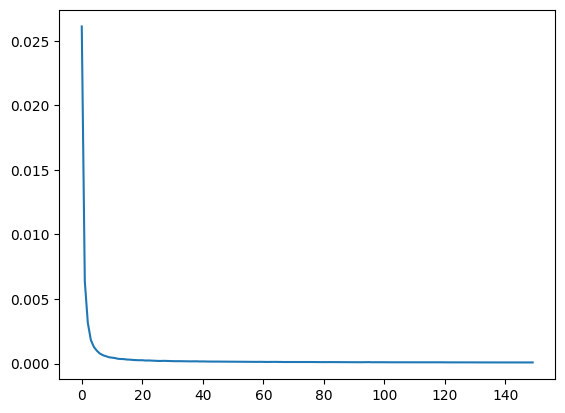

In [19]:
loss_values =[]
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        output_teacher = teacherNetwork(inputs)
        _, predicted_teacher = torch.max(output_teacher, 1)
        output_student = studentnetwork_distil  (inputs)
        _, predicted_student = torch.max(output_student, 1)

        #To implement the softmax principle of knowledge distiallation of teacher model into the student.
        loss1 = F.kl_div(torch.nn.functional.log_softmax(output_student/T,dim=1),torch.nn.functional.softmax(output_teacher/T,dim=1), reduction='batchmean')
        loss2 = criterion(output_student,labels)
        loss = ((1-l)*loss1*(T**2)) + (l * loss2)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / len(trainset))
            running_loss = 0.0

plt.plot(loss_values)
print('Finished Training')

## **Testing student network with distillation**

In [21]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the student network to the selected device
studentnetwork_distil = studentnetwork_distil.to(device)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move images and labels to the selected device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = studentnetwork_distil(images)
        _, predicted = torch.max(outputs, 1)

        # Accumulate accuracy count
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if total % 1000 == 999:  # Print every 1000 samples
            print('[%5d] completed' % (total + 1))

# Print final accuracy
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))
wrong_pred = total - correct
print('Wrong predictions on the 10000 test images:', wrong_pred, 'out of', total)


Accuracy of the network on the 10000 test images: 98.79 %
Wrong predictions on the 10000 test images: 121 out of 10000


Our replication results align with the main point of the paper: while the cumbersome model achieves the high test accuracy, distilled student network with soft target performs better than undistilled student network with hard targets.

The results we got are:

Test accuracy of teacher network: 98.85% (115 errors in 10000 test samples).

Test accuracy of undistilled student network: 98.78% (122 errors in 10000 test samples).

Test accuracy of distilled student network: 98.79% (121 errors in 10000 test samples).

Under such pararmeter setting, we could not exactly replicate the results presented in paper, teacher network produces 67 test errors, undistilled student network achieves 146 errors and distilled student network achieves 74 test errors. This is partly because we do not know the best choice for lots of hyperparameters, such as
 (the weight we assign to hard target function), the learning rate, the batch size, etc. In addition, based on the computation resource we have, it took too much time to do cross-validation.

However, as seen from the results above, we successfully showed that the distilled student network performs better than undistilled student network (the model with hard targets) on test dataset.